# Project Proposal 

### 1. Introduction
The video game industry began in the 1950s as simple games and simulations. Pixelated screens and limited sound have become a distant memory as video games are offering photorealistic graphics and pushing the frontier of stimulational reality. Video games is one of the largest sectors in the entertainment industry. With the fast growing market, the gaming industry requires marketing data to help predict the sales for their new games. However, in recent years, the emergence of social networks and the developments of mobile games have greatly impacted traditional video games. Careful marketing planning is crucial when a new game is introduced to the market. Therefore, our research question is to predict the sales in the European market for a new action or sports video game given North America and other regional sales. To achieve this, we used a dataset generated by scraping of vgchartz.com. It contains a list of video games with sales greater than 100,000 copies from 1980 to 2017.

**Dataset:**
* Our dataset can be found at <a href="https://github.com/GregorUT/vgchartzScrape.git" target="_blank">this link</a>.
* Dataset is scraped from <a href="https://www.vgchartz.com" target="_blank">Vgchartz website</a>.
* <a href="https://www.kaggle.com/gregorut/videogamesales" target="_blank">Reference</a> can be found here.


In [16]:
# * `Name`: name of the game
# * `Platform`: platform of the game release
# * `Year`: year that the game is released
# * `Genre`: genre of the game
# * `Publisher`: publisher of the game
# * `NA_Sales`: sales in North America (in millions)
# * `EU_Sales`: sales in Europe (in millions)
# * `JP_Sales`: sales in Japan (in millions)
# * `Other_sales`: sales in other countries (in millions)
# * `Global_sales`: total worldwide sales

In [17]:
#library needed for this project
library(tidyverse)
library(dplyr)
library(RColorBrewer)
library(tidyr)
library(tidymodels)
library(repr)

**1.1 Load data onto Jyputer notebook**

In [18]:
raw_vgdata <- read_csv("vgsales.csv")
summary(raw_vgdata)

Parsed with column specification:
cols(
  Rank = col_double(),
  Name = col_character(),
  Platform = col_character(),
  Year = col_character(),
  Genre = col_character(),
  Publisher = col_character(),
  NA_Sales = col_double(),
  EU_Sales = col_double(),
  JP_Sales = col_double(),
  Other_Sales = col_double(),
  Global_Sales = col_double()
)



      Rank           Name             Platform             Year          
 Min.   :    1   Length:16598       Length:16598       Length:16598      
 1st Qu.: 4151   Class :character   Class :character   Class :character  
 Median : 8300   Mode  :character   Mode  :character   Mode  :character  
 Mean   : 8301                                                           
 3rd Qu.:12450                                                           
 Max.   :16600                                                           
    Genre            Publisher            NA_Sales          EU_Sales      
 Length:16598       Length:16598       Min.   : 0.0000   Min.   : 0.0000  
 Class :character   Class :character   1st Qu.: 0.0000   1st Qu.: 0.0000  
 Mode  :character   Mode  :character   Median : 0.0800   Median : 0.0200  
                                       Mean   : 0.2647   Mean   : 0.1467  
                                       3rd Qu.: 0.2400   3rd Qu.: 0.1100  
                                

**1.2 Removal of Missing Data**

Dataset is in tidy format, therefore, no additional cleaning and wrangling is necessary. However, missing data is removed by using `omit.na` function assuming they are missing at random. Moreover, we focused on games published prior to 2017 since the sales data is incomplete.

In [19]:
vg <- na.omit(raw_vgdata) %>%
      filter(Year<2017)

head(vg)

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
6,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26


**1.3 Split Training and Testing Tests**

In [20]:
set.seed(9999) 

vg_split <- initial_split(vg, prop = 0.75, strata = EU_Sales)  
vg_train <- training(vg_split)   
vg_test <- testing(vg_split)

In [27]:
#check if there is missing data
sum(is.na(vg_train))

[1] 0

### 2. Exploratory Data Analysis

**2.1 Visualization**

`summarise()` ungrouping output (override with `.groups` argument)



Genre,n
<chr>,<int>
Action,2433
Sports,1723
Misc,1286
Role-Playing,1090
Adventure,979
Shooter,965
Racing,928
Platform,665
Simulation,634


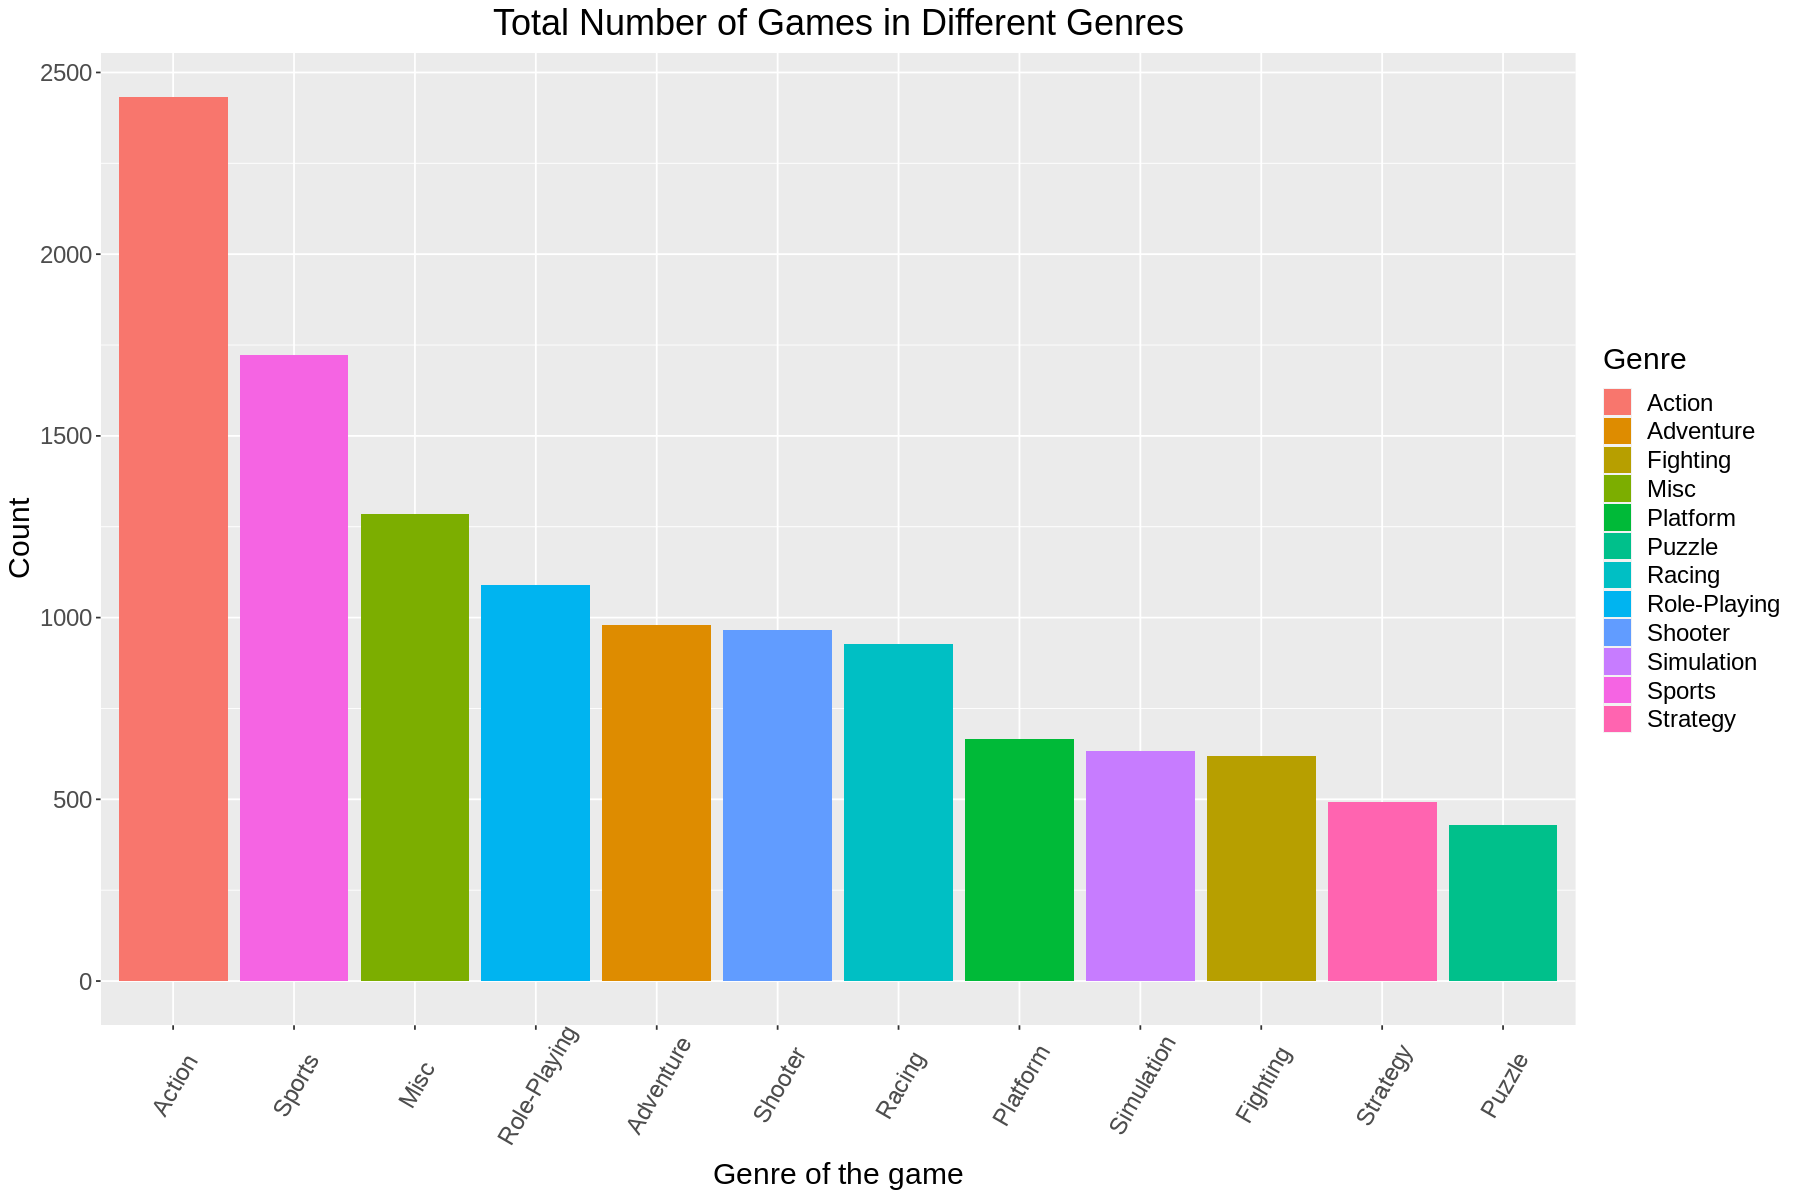

In [39]:
vg_genre <- vg_train %>%
  group_by(Genre) %>%
  summarise(n=n())%>%
  arrange(desc(n))

vg_genre

#Figure 1
#visualization on the number of games in each genre
options(repr.plot.width = 15, repr.plot.height = 10)
vg_genre_plot <- vg_genre%>%
  ggplot(aes(x = reorder(Genre, -n), y = n, fill = Genre))+
  geom_bar(stat = 'identity')+
  labs(x = "Genre of the game",
       y = "Count", 
       fill = "Genre",
       title = "Total Number of Games in Different Genres")+
  scale_color_brewer(palette = "Set3")+
  theme(axis.text.x = element_text(angle = 60, vjust = 0.6, hjust=0.5), 
        text = element_text(size = 18))+
  theme(plot.title = element_text(hjust = 0.5))

vg_genre_plot

<span style="color:gray">Figure 1. Total number of games sold for the top 7 genres</span>

The above graph shows that action and sport games are the two most frequently sold gaming genres globally. 

`summarise()` regrouping output by 'Year' (override with `.groups` argument)



Year,Genre,total_sales
<chr>,<chr>,<dbl>
1980,Action,0.34
1980,Shooter,7.07
1980,Sports,0.49
1981,Action,11.86
1981,Platform,2.43
1981,Racing,0.48


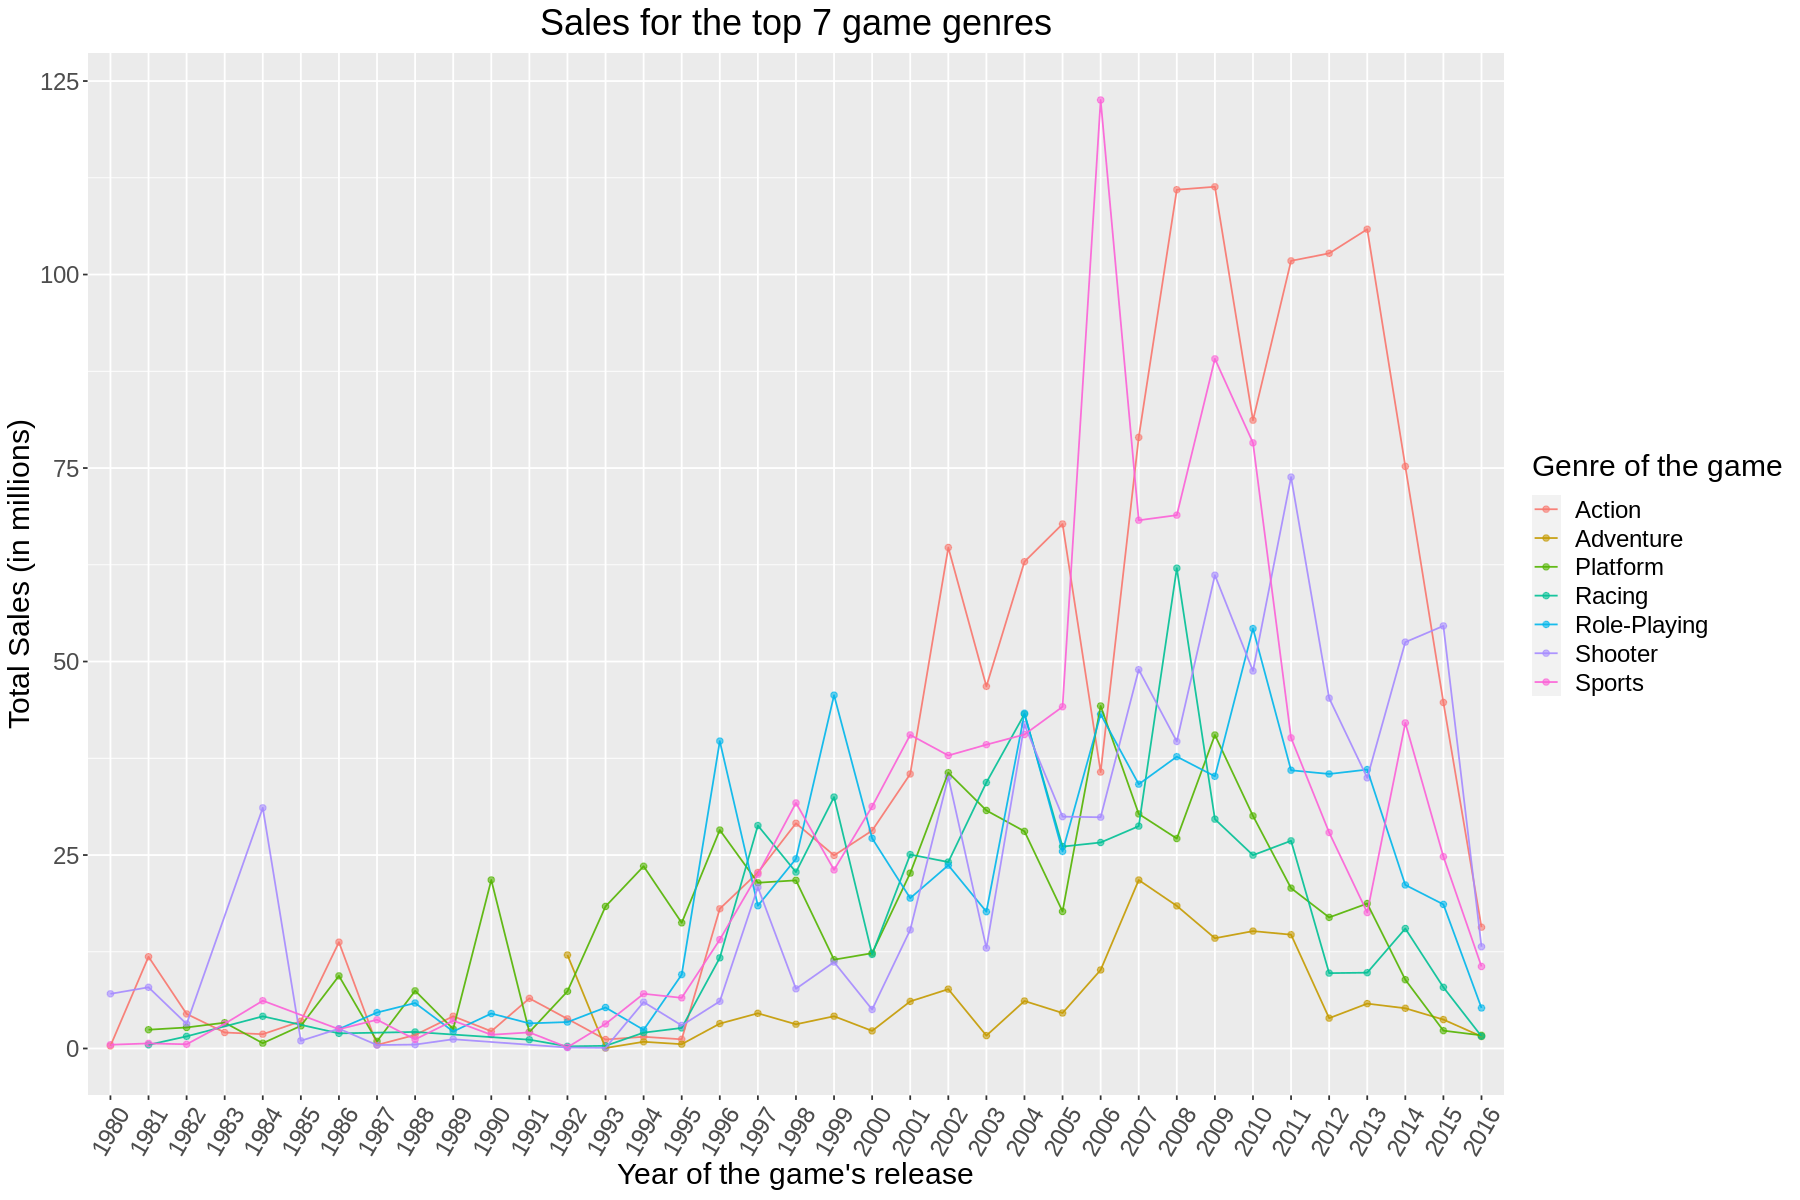

In [40]:
#summarize the different game genres' global sales
genre_gbsales <- vg_train %>%
  filter(Genre %in% c("Action","Sports","Role-Playing","Shooter",
                      "Adventure","Racing", "Platform"))%>%
    group_by(Year,Genre)%>%
    summarize(total_sales = sum(Global_Sales))
    
head(genre_gbsales)

#Figure 2
#plot top 7 genres' global sales vs year of the game release
#only 7 out of 12 genres were selected for better visualization
options(repr.plot.width = 15, repr.plot.height = 10)
genre_gbsales_plot <- genre_gbsales %>%
  ggplot(aes(x = Year, y = total_sales, colour = Genre, group = Genre))+
  geom_point(alpha = 0.6)+
  geom_line(alpha = 0.9)+
    labs(x = "Year of the game's release",
         y = "Total Sales (in millions)", 
         colour = "Genre of the game",
         title = "Sales for the top 7 game genres")+
    theme(axis.text.x = element_text(angle = 60, vjust = 0.5, hjust=0.5), 
          text = element_text(size = 18))+
    theme(plot.title = element_text(hjust = 0.5))

genre_gbsales_plot

<span style="color:gray">Figure 2. Global sales for the top 7 genres</span>

The graph above plotted total amount of sales of top 7 gaming genres over the years. Based on *Figure 1* and *Figure 2*, we observed that the top 3 popular gaming genres are action, sports and shooter within last 10 years. Therefore, we decided to analyze the regional sales correlation for action, sports and shooter games. 

## 3. Methods

In [34]:
vg_genre <- vg_train %>%
  group_by(Genre) %>%
  summarise(n=n())%>%
  arrange(desc(n))

head(vg_genre)

`summarise()` ungrouping output (override with `.groups` argument)



Genre,n
<chr>,<int>
Action,2433
Sports,1723
Misc,1286
Role-Playing,1090
Adventure,979
Shooter,965


Using `nrow()`, we confirmed that we have enough observations for analysis.

In [35]:
#filter on two combinations of predictors: Action with either Sports and Shooter
vg_action_sp <- filter(vg_train, Genre == "Sports" | Genre == "Action")
nrow(vg_action_sp)

vg_action_shooter <- filter(vg_train, Genre == "Shooter" | Genre == "Action")
nrow(vg_action_shooter)

[1] 4156

[1] 3398

In [37]:
#correlation analysis, rounding the Matrics values to 2 decimal places
vg_cor_sp<- vg_action_sp %>% 
  select(-(Rank:Publisher))

sales_cor_sp <- round(cor(vg_cor_sp),2)%>%
  as.matrix()

sales_cor_sp 

vg_cor_shooter<- vg_action_shooter %>% 
  select(-(Rank:Publisher))

sales_cor_shooter <- round(cor(vg_cor_shooter),2)%>%
  as.matrix()

sales_cor_shooter

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
NA_Sales,1.00,0.86,0.40,0.73,0.96
EU_Sales,0.86,1.00,0.41,0.70,0.94
JP_Sales,0.40,0.41,1.00,0.30,0.51
Other_Sales,0.73,0.70,0.30,1.00,0.80
Global_Sales,0.96,0.94,0.51,0.80,1.00


,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
NA_Sales,1.00,0.68,0.23,0.57,0.93
EU_Sales,0.68,1.00,0.26,0.64,0.87
JP_Sales,0.23,0.26,1.00,0.19,0.36
Other_Sales,0.57,0.64,0.19,1.00,0.74
Global_Sales,0.93,0.87,0.36,0.74,1.00


<span style="color:gray">Table 1. Correlation Matrics for 2 dataframes. Top: filtered with Action and Sports. Bottom: filtered with Action and Shooter. </span>

According to Table 1, sports and action filtered dataset has higher correlation values between `EU_Sales` and other regional sales. Therefore, in the later analysis we will focus only on sports and action games. 

Based on our two predictors, the **accuracy vs K** values will be presented in a scatter plot to select the appropriate K value for the highest accuracy, therefore, render the best regression model for this project.

## Expected Outcomes

**What do you expect to find?**
<br>Our goal for this project is to predict the sales in Europe for a new action or sports game using sales in North America and other regional sales. With this regression model, we expect to accurately predict the sale values in the test set.

**What impact could such findings have?**
<br>Using our prediction model, it might be useful for video game publishers to predict the sales of new video games in new markets. This could help gaming companies to focus their advertisements in one specific region, ultimately maximizing their revenues. 

**What future questions could this lead to?**
<br>There are other factors we can investigate, for example, gaming influencers can impact audience's purchasing decisions. One strategy a gaming company can adapt is to collaborate with the influencers, thus, increasing profits.